<a href="https://colab.research.google.com/github/yuvalira/SER-Sinc-Speech-Emotion-Recognition-via-Multi-scale-Sinc-Filters-/blob/main/data_loading%20/Data_Preparation_and_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation and Augmentation**

This notebook prepares the RAVDESS emotional speech dataset for training a speech emotion recognition (SER) model. It includes mono conversion, resampling to 16kHz, normalization, and fixed-length trimming or padding. To improve model robustness, a custom emotion-aware augmentation pipeline is applied to the training set only, generating three additional augmented versions per sample using label-specific transformations (e.g., pitch shift, noise injection). All processed samples are saved as .pt files. The final dataset is zipped and exported to Google Drive.


## 1. Setup and Imports
Import the necessary libraries for audio processing, file handling, and dataset management.

In [1]:
import os
import glob
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import torchaudio.transforms as T
from tqdm import tqdm
from google.colab import drive

## 2. Dataset Download and Extraction
Use the Kaggle API to download and extract the RAVDESS emotional speech dataset.

In [2]:
# Upload kaggle.json API token
from google.colab import files
files.upload()  # Select your kaggle.json file here

# Move kaggle.json to the correct location and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the RAVDESS dataset from Kaggle
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

# Force unzip even if files already exist (overwrite silently)
!unzip -o -q ravdess-emotional-speech-audio.zip -d ravdess_data

# List the contents to confirm
!ls ravdess_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 95% 407M/429M [00:07<00:00, 65.9MB/s]
100% 429M/429M [00:07<00:00, 62.3MB/s]
Actor_01  Actor_06  Actor_11  Actor_16	Actor_21
Actor_02  Actor_07  Actor_12  Actor_17	Actor_22
Actor_03  Actor_08  Actor_13  Actor_18	Actor_23
Actor_04  Actor_09  Actor_14  Actor_19	Actor_24
Actor_05  Actor_10  Actor_15  Actor_20	audio_speech_actors_01-24


## 3. Custom Dataset Class: RAVDESSDataset

Define a custom PyTorch Dataset class that handles:
* Audio loading from WAV files
* Stereo to mono conversion
* Resampling to a uniform sample rate (16kHz)
* Padding or trimming all waveforms to a fixed 3-second duration
* Normalization to unit amplitude

This class also includes a mapping from RAVDESS file names to emotion labels (0–7), based on the emotion code embedded in each filename.



In [3]:
class RAVDESSDataset(Dataset):
    def __init__(self, root_dir, sample_rate=16000, duration=3, augment=False):
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.fixed_length = sample_rate * duration
        self.augment = augment
        self.augmenter = AudioAugment() if augment else None

        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.wav'), recursive=True)

        self.label_map = {
            '01': 0,  # neutral
            '02': 1,  # calm
            '03': 2,  # happy
            '04': 3,  # sad
            '05': 4,  # angry
            '06': 5,  # fearful
            '07': 6,  # disgust
            '08': 7   # surprised
        }

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]

        # Load and preprocess waveform
        waveform, sr = torchaudio.load(file_path)

        # Convert stereo to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample if needed
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)

        # Fix length
        if waveform.shape[1] > self.fixed_length:
            waveform = waveform[:, :self.fixed_length]
        elif waveform.shape[1] < self.fixed_length:
            padding = self.fixed_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # Augment if enabled
        if self.augmenter:
            waveform = self.augmenter(waveform)

        # Label from filename
        filename = os.path.basename(file_path)
        emotion_code = filename.split("-")[2]
        label = self.label_map[emotion_code]

        return waveform, label

## 4. Dataset Inspection and Waveform Visualization
Instantiate the dataset, select a sample, and visualize its waveform and corresponding label using Matplotlib.

In [4]:
# Set dataset root path
dataset_path = "ravdess_data/"  # this is where the files were unzipped

# Create dataset instance
full_dataset = RAVDESSDataset(root_dir=dataset_path)

Label index: 3
Waveform shape: torch.Size([1, 48000])


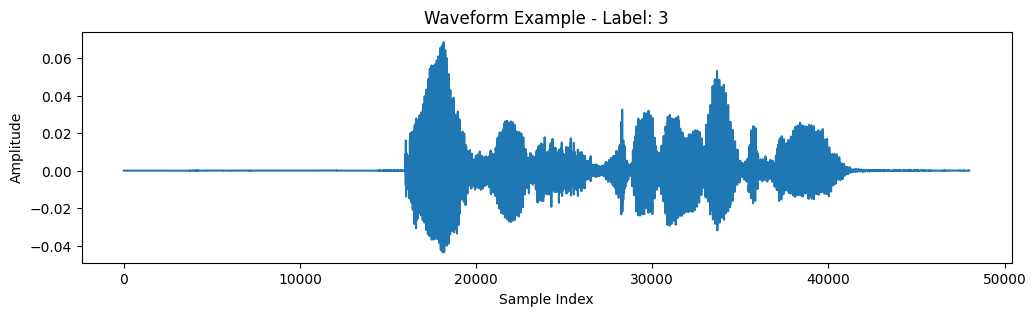

In [5]:
# Visualize one sample from the dataset
waveform, label = full_dataset[0]

print(f"Label index: {label}")
print(f"Waveform shape: {waveform.shape}")  # should be (48000,)

# Plot the waveform
plt.figure(figsize=(12, 3))
plt.plot(waveform.squeeze(0).numpy())
plt.title(f"Waveform Example - Label: {label}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

## 5. Dataset Splitting
Split the dataset into training, validation, and test sets using PyTorch’s random_split function. Only the training set is augmented in later steps.

In [6]:
# Total dataset size
total_size = len(full_dataset)

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Compute lengths
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # to handle rounding

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducible split
)

print(f"Total samples: {total_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total samples: 2880
Training set size: 2304
Validation set size: 288
Test set size: 288


## 6. Train Set Augmentation
Define an EmotionAwareAugment class that applies data augmentation to the training set only. Each sample is augmented three times using transformations that depend on the emotion label, such as:

* Pitch shifting
* Volume adjustment
* Time stretching
* Time shifting
* Noise injection

These augmentations help improve model robustness by introducing controlled variability in the training data.



In [7]:
# Extract file paths of training set from random_split
train_indices = train_dataset.indices  # Get indices from the training Subset
train_files = [full_dataset.file_paths[i] for i in train_indices]  # Map indices to file paths

# Print summary
print(f"Number of training files: {len(train_files)}")
print(f"First training file path: {train_files[0]}")

Number of training files: 2304
First training file path: ravdess_data/audio_speech_actors_01-24/Actor_03/03-01-07-02-01-01-03.wav


In [14]:
class EmotionAwareAugment:
    def __init__(self, sample_rate=16000, apply_prob=0.8):
        self.sample_rate = sample_rate
        self.apply_prob = apply_prob

    def __call__(self, waveform, label):
        # Label: integer 0-7 representing the emotion class
        if random.random() > self.apply_prob:
            return waveform  # no augmentation this time

        if label == 2:  # happy
            waveform = self.pitch_shift(waveform, steps=1)
            waveform = self.volume_change(waveform, factor=1.1)
        elif label == 3:  # sad
            waveform = self.pitch_shift(waveform, steps=-1)
            waveform = self.time_stretch(waveform, factor=0.95)
        elif label == 4:  # angry
            waveform = self.volume_change(waveform, factor=1.2)
            waveform = self.add_noise(waveform, noise_std=0.01)
        elif label == 1 or label == 0:  # calm / neutral
            waveform = self.time_shift(waveform, max_shift=1000)
        elif label == 5:  # fearful
            waveform = self.pitch_shift(waveform, steps=1)
            waveform = self.add_noise(waveform)
        elif label == 6:  # disgust
            waveform = self.volume_change(waveform, factor=1.1)
        elif label == 7:  # surprised
            waveform = self.pitch_shift(waveform, steps=2)
            waveform = self.volume_change(waveform, factor=1.2)

        return waveform

    def pitch_shift(self, waveform, steps=1):
        transform = T.PitchShift(
            sample_rate=self.sample_rate,
            n_steps=steps
        ).to(waveform.device)  # this fixes the window device mismatch
        return transform(waveform)

    def time_stretch(self, waveform, factor=0.95):
        new_sr = int(self.sample_rate * factor)
        resample = T.Resample(orig_freq=self.sample_rate, new_freq=new_sr).to(waveform.device)
        return resample(waveform)

    def volume_change(self, waveform, factor=1.1):
        return waveform * factor

    def add_noise(self, waveform, noise_std=0.005):
        noise = torch.randn_like(waveform) * noise_std
        return waveform + noise

    def time_shift(self, waveform, max_shift=1600):
        shift = random.randint(-max_shift, max_shift)
        return torch.roll(waveform, shifts=shift, dims=-1)

In [9]:
output_dir = "/content/expanded_dataset"  # new dataset folder
os.makedirs(output_dir, exist_ok=True)    # create folder if it doesn't exist

In [15]:
# Parameters
sample_rate = 16000
fixed_length = sample_rate * 3
num_augmentations_per_sample = 3
output_dir = "/content/expanded_dataset"
os.makedirs(output_dir, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the emotion-aware augmenter
augmenter = EmotionAwareAugment(sample_rate=sample_rate)

# Label mapping
label_map = {
    '01': 0, '02': 1, '03': 2, '04': 3,
    '05': 4, '06': 5, '07': 6, '08': 7
}

# Counter for saved files
counter = 0

for path in tqdm(train_files, desc="Expanding dataset with GPU"):
    waveform, sr = torchaudio.load(path)

    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Move to GPU
    waveform = waveform.to(device).float()

    # Resample
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(
            orig_freq=sr, new_freq=sample_rate).to(device)
        waveform = resampler(waveform)

    # Trim or pad
    if waveform.shape[1] > fixed_length:
        waveform = waveform[:, :fixed_length]
    elif waveform.shape[1] < fixed_length:
        padding = fixed_length - waveform.shape[1]
        waveform = F.pad(waveform, (0, padding))

    # Normalize
    waveform = waveform / waveform.abs().max()

    # Get label from filename
    filename = os.path.basename(path)
    emotion_code = filename.split("-")[2]
    label = label_map[emotion_code]

    # Save original (move to CPU before saving)
    torch.save({
        "waveform": waveform.cpu(),
        "label": label
    }, f"{output_dir}/sample_{counter}.pt")
    counter += 1

    # Save augmented versions
    for _ in range(num_augmentations_per_sample):
        aug_waveform = augmenter(waveform.clone(), label)  # stays on GPU
        torch.save({
            "waveform": aug_waveform.cpu(),
            "label": label
        }, f"{output_dir}/sample_{counter}.pt")
        counter += 1

print(f"\n Saved {counter} samples to {output_dir} using GPU acceleration.")


Expanding dataset with GPU: 100%|██████████| 2304/2304 [08:26<00:00,  4.55it/s]


 Saved 9216 samples to /content/expanded_dataset using GPU acceleration.


## 7. Saving Datasets
Save the original and augmented training samples (as .pt files) into a local folder. The complete set is then zipped and copied to Google Drive for easy reuse in training notebooks.

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# Zip augmented dataset
zip_path = "/content/expanded_dataset.zip"
if not os.path.exists(zip_path):
    !zip -r {zip_path} /content/expanded_dataset

# Define destination path Google Drive
drive_destination = "/content/drive/MyDrive/expanded_dataset.zip"

# Copy ZIP to Drive
!cp {zip_path} "{drive_destination}"
print(f"Dataset successfully copied to Google Drive at: {drive_destination}")

Mounted at /content/drive
Dataset successfully copied to Google Drive at: /content/drive/MyDrive/expanded_dataset.zip


Save validation and test sets into Google Drive

In [7]:
def save_subset_as_pt(subset, full_dataset, output_dir, prefix):
    os.makedirs(output_dir, exist_ok=True)

    for idx, i in enumerate(subset.indices):
        waveform, label = full_dataset[i]
        torch.save(
            {"waveform": waveform, "label": label},
            f"{output_dir}/{prefix}_sample_{idx}.pt"
        )
    print(f"Saved {len(subset)} samples to {output_dir}")

# Save validation set
save_subset_as_pt(val_dataset, full_dataset, output_dir="val_data", prefix="val")

# Save test set
save_subset_as_pt(test_dataset, full_dataset, output_dir="test_data", prefix="test")

Saved 288 samples to val_data
Saved 288 samples to test_data


In [8]:
# Zip validation set
!zip -r val_data.zip val_data > /dev/null

# Zip test set
!zip -r test_data.zip test_data > /dev/null

print("val_data.zip and test_data.zip created successfully.")

val_data.zip and test_data.zip created successfully.


In [9]:
# Copy zip files to your Drive root
!cp val_data.zip /content/drive/MyDrive/
!cp test_data.zip /content/drive/MyDrive/

print(" Files copied to your Google Drive (MyDrive).")

Mounted at /content/drive
 Files copied to your Google Drive (MyDrive).
